In [1]:
import numpy as np
import pymc3 as mc
import matplotlib.pyplot as plt
import pandas as pd
from local.lib import histos2d as h2d
from scipy.integrate import quad
from scipy import stats
from scipy.optimize import minimize
from progressbar import progressbar as pbar
from rlxutils.optimization import coordinate_descent_minimize

%matplotlib inline

## Linear regression with bayesian inference


Classically

$$y^{(i)} = m x^{(i)} + b$$

But now, we assume each $y^{(i)}$ follows a probability distirbution:

$$P(y^{(i)}|m,b,x^{(i)}) \sim \mathcal{N}(\mu = m x^{(i)}+b, \sigma = 1)$$

and sample from the posterior, given Bayes theorem:

$$P(m,b|y^{(i)},x^{(i)}) = \frac{P(y^{(i)}|m,b,x^{(i)}) P(m)P(b)}{\int\int P(y^{(i)}|m,b,x^{(i)}) \text{d}m\text{d}s}$$

where $P(m)$ and $P(b)$ are the priors on the paramters, which we set to $\text{U}([-10,10])$ (uniform distribution)

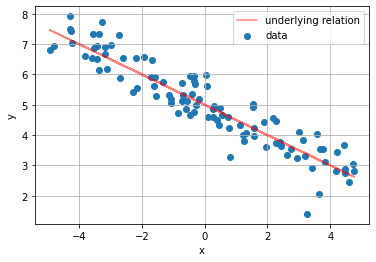

In [2]:
x = np.random.random(100)*10-5
m,b = -0.5,5
yb = x*m+b
y = yb+np.random.normal(size=len(x))*.5

plt.plot(x, yb, color="red", alpha=.5, label="underlying relation")
plt.scatter(x, y, label="data")
plt.xlabel("x"); plt.ylabel("y"); plt.grid(); plt.legend();

In [3]:
with mc.Model() as model:
    mV = mc.Uniform('m', -10,10)
    bV = mc.Uniform('b', -10,10)
    
    y_obs = mc.Normal('y_obs', mu=mV*x+bV, sigma=2, observed=y)
    trace = mc.sample(5000, cores=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [b, m]


Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000 + 25_000 draws total) took 4 seconds.


/opt/anaconda/envs/p38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


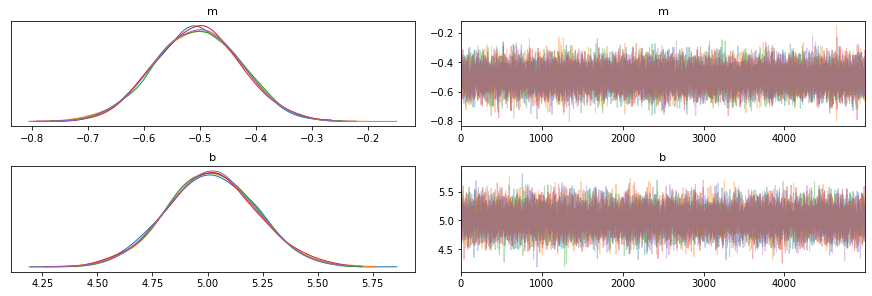

In [4]:
mc.plot_trace(trace);

In [5]:
pd.DataFrame([i for i in trace])[["m", "b"]].mean()

m   -0.504178
b    5.018158
dtype: float64

## sampling from a mixture of Gaussians by hand


- $P'_s$: nominal probability of observing signal
- $P'_b=1-P'_s$: nominal probability of observing background
- $\mu$: event intensity of the signal

Higher $\mu$ represent higher number of signal events observed and thus need to normalize probabilities

- $z=P'_b+\mu P'_s$
- $P_s=\mu P'_s/z$
- $P_b= P'_b/z$


Model

- $k \sim Categorical[P_b,P_s]$
- $x$
   - $\sim \mathcal{N}(\mu_s, \sigma_s)$ if $k=s$
   - $\sim Exp(t)$ if $k=b$

- https://indico.cern.ch/category/6015/attachments/192/631/Statistics_Fitting_II.pdf
- https://www.physi.uni-heidelberg.de/~menzemer/Stat10/statistik_15.06.10.pdf

In [2]:
n_bins = 40
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
bin_edges

array([  0.        ,   4.61538462,   9.23076923,  13.84615385,
        18.46153846,  23.07692308,  27.69230769,  32.30769231,
        36.92307692,  41.53846154,  46.15384615,  50.76923077,
        55.38461538,  60.        ,  64.61538462,  69.23076923,
        73.84615385,  78.46153846,  83.07692308,  87.69230769,
        92.30769231,  96.92307692, 101.53846154, 106.15384615,
       110.76923077, 115.38461538, 120.        , 124.61538462,
       129.23076923, 133.84615385, 138.46153846, 143.07692308,
       147.69230769, 152.30769231, 156.92307692, 161.53846154,
       166.15384615, 170.76923077, 175.38461538, 180.        ,
                inf])

In [3]:

makebins = lambda x, bin_edges: np.r_[[np.sum((x>=bin_edges[i])&(x<bin_edges[i+1])) \
                                       for i in range(len(bin_edges)-1)]]

def plotbins(bins, bin_edges, **kwargs):
    bin_width = (bin_edges[2]-bin_edges[1])
    plt.bar(bin_edges[:-1]+bin_width/2, bins, width=bin_width*.9, **kwargs)


In [4]:
pois_pmf = lambda x, mu: np.r_[[np.exp(-mu + i*np.log(mu) - logfactorial(i)) for i in x]]
gaus_pdf = lambda x, mu, sigma: np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))
pois_pdf = lambda x, mu: gaus_pdf(np.r_[x], mu, np.sqrt(mu)) 
exp_pdf  = lambda x, t: t * np.exp(-t*x)

class BS_continuous:
        
    def __init__(self, t, mu_s, sigma_s, mu, stot, btot, bin_edges, use_gaussian_appoximation=False):
        # render all params positive
        t, mu_s, sigma_s, mu, stot, btot = np.abs([t, mu_s, sigma_s, mu, stot, btot])
        stot,btot = int(stot), int(btot)
        self.t, self.mu_s, self.sigma_s, self.mu, self.stot, self.btot = t, mu_s, sigma_s, mu, stot, btot
        self.params = {'stot': self.stot, 'btot': self.btot, 't': self.t, 'mu_s': self.mu_s, 'sigma_s': self.sigma_s, "mu": self.mu}      
        
        # base continuous distributions
        self.b = stats.expon(scale=1/t)
        self.s = stats.norm(loc=mu_s, scale=sigma_s)       

        self.bin_edges = bin_edges

        # compute theoretical distribution for each bin
        self.si = self.stot*pd.Series([self.s.cdf(i) for i in self.bin_edges]).diff().dropna().values
        self.bi = self.btot*pd.Series([self.b.cdf(i) for i in self.bin_edges]).diff().dropna().values
        if len(self.si)!=len(self.bi):
            print ("ERROR!!", self.t, self.mu_s, self.sigma_s, mu, btot, stot)
        self.ni = self.mu * self.si + self.bi  

        self.tot = self.mu*self.stot + self.btot
        
        # compute binned distributions
        self.bins_distributions = [stats.poisson(mu=self.ni[i]) for i in range(len(self.ni))]               
        
    def clone(self, t=None, mu_s=None, sigma_s=None, mu=None, stot=None, btot=None):
        t       = t or self.t
        mu_s    = mu_s or self.mu_s
        sigma_s = sigma_s or self.sigma_s
        mu      = mu or self.mu
        stot    = stot or self.stot
        btot    = btot or self.btot
        return self.__class__(t, mu_s, sigma_s, mu, stot, btot, self.bin_edges)
        
    def pdf(self, x):
        return (self.stot*self.mu * gaus_pdf(x, self.mu_s, self.sigma_s) + self.btot*exp_pdf(x, self.t))\
               /(self.stot*self.mu + self.btot)
    
    def logpdf(self, x):
        r = self.pdf(x)
        #r[r<1e-50] = 1e-50
        return np.log(r)    
    
    def rvs(self, separated=False):        
        xb = self.b.rvs(self.btot)
        xs = self.s.rvs(int(self.stot*self.mu))
        x = np.random.permutation(np.concatenate((xb,xs)))
        if not separated:
            return x
        else:
            return x,xb,xs
    
    def rvs_binned(self, n_histograms):
        
        r = []
        for _ in pbar(range(n_histograms)):
            x_samples = self.rvs()
            bins = np.r_[[np.sum((x_samples>=self.bin_edges[i])&(x_samples<self.bin_edges[i+1])) \
                          for i in range(len(self.bin_edges)-1)]]
            r.append(bins)
            
        return np.r_[r]
    
    def get_random_params(self, params_names):
        params_ranges = {"mu_s":    [self.bin_edges[0], self.bin_edges[-2]],
                         "sigma_s": [1e-3, 10],
                         "btot":    [0, 2000],
                         "stot":    [0, 2000],
                         "t":       [1e-3, 10],
                         "mu":      [0,10]}          
        
        def get_random_init(param_name):
            xmin, xmax = params_ranges[param_name][0], params_ranges[param_name][1]
            x = np.random.random()
            return x*(xmax-xmin)+xmin
        
        x0 = np.r_[[get_random_init(i) for i in params_names]]
        return x0    
    
    def MLE(self, fixed_params, observed_data, verbose=False, **kw_minimizer_args):
        """
        computes MLE for all params except the ones listed in fixed_params
        """
        fixed_params = {k:self.params[k] for k in fixed_params}
        params_names = list(self.params.keys())

        
        params_ranges = {"mu_s":    [self.bin_edges[0], self.bin_edges[-2]],
                         "sigma_s": [1e-3, 10],
                         "btot":    [0, 5000],
                         "stot":    [0, 5000],
                         "t":       [1e-3, 10],
                         "mu":      [0,10]}          
        
        def get_random_init(param_name):
            xmin, xmax = params_ranges[param_name][0], params_ranges[param_name][1]
            x = np.random.random()
            return x*(xmax-xmin)+xmin
        
        def log_likelihood(varparams_values):
            assert len(varparams_values)+len(fixed_params)==len(params_names), "mismatched params"
            params = {**fixed_params, **{k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], varparams_values)}}
            r = -BS_continuous(**params, bin_edges=self.bin_edges).logpdf(observed_data)
            return np.sum(r)

        x0 = np.r_[[get_random_init(i) for i in params_names if not i in fixed_params.keys()]]
        #x0 = self.get_random_params(observed_histogram, [i for i in params_names if not i in fixed_params.keys()])
        
        r = minimize(log_likelihood, method="Nelder-Mead", tol=1e-20, x0=x0)

        #r = coordinate_descent_minimize(log_likelihood, x0=x0, **kw_minimizer_args)
        
        optimized_params = {k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], r.x)}
    
        if verbose:
            print ("fixed params    ", fixed_params)
            print ("allowable paramss ranges ", params_ranges)
            print ("init params     ", {k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], x0)})
            print ("optimized params", optimized_params)
            print ("expected params ", {i:self.params[i] for i in optimized_params.keys()})
            print ()
            print (r)
        return optimized_params, \
               self.clone(**{**fixed_params, **optimized_params})    

In [5]:
bd = BS_continuous(t=0.03, mu_s=60, sigma_s=6, mu=3, stot=100, btot=1000, bin_edges=bin_edges)
self = bd
x = bd.rvs()
x.shape

(1300,)

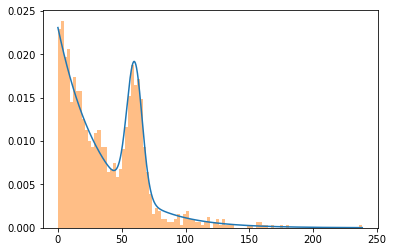

In [6]:
xr = np.linspace(0,np.max(x),1000)
plt.plot(xr, bd.pdf(xr))
plt.hist(x, bins=100, alpha=.5, density=True);

### check integration of continuous pdf by bins = $n_i$ per bin

In [7]:
bins = np.vstack((self.bin_edges[:-1], self.bin_edges[1:])).T
pbins = np.r_[[quad(lambda x: self.pdf(x), *i)[0] for i in bins]]

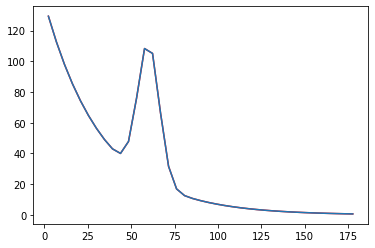

In [8]:
plt.plot(bins.mean(axis=1)[:-1], pbins[:-1]*self.tot, color="red")
plt.plot(bins.mean(axis=1)[:-1], self.ni[:-1])


## check histogram distributions

- by sampling the continuous pdf
- by sampling the poison pdf of each bin

In [9]:
n = 20000
xb = bd.rvs_binned(n)
xb.shape

100% (20000 of 20000) |##################| Elapsed Time: 0:00:10 Time:  0:00:10


(20000, 40)

In [10]:
hb = np.r_[[i.rvs(n) for i in bd.bins_distributions]].T
hb.shape

(20000, 40)

In [11]:
xbm = np.mean(xb, axis=0)
xbs = np.std(xb, axis=0)
hbm = np.mean(hb, axis=0)
hbs = np.std(hb, axis=0)

In [12]:
xbs[0], hbs[0]

(10.672129477756332, 11.315610190793956)

In [13]:
hb.shape

(20000, 40)

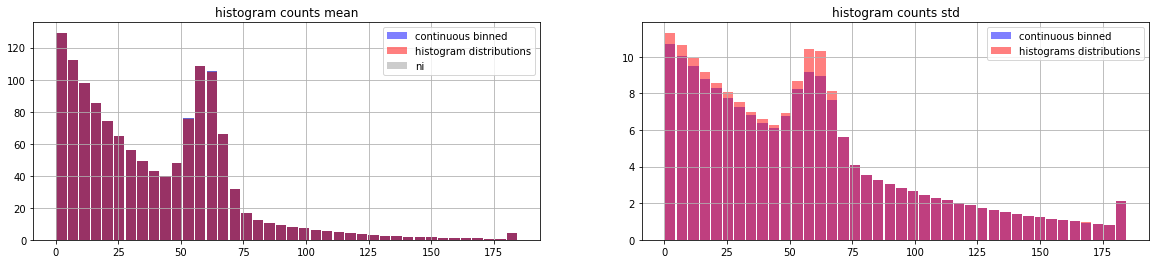

In [14]:
plt.figure(figsize=(20,4))
plt.subplot(121)
plotbins(xbm, bd.bin_edges, alpha=.5, color="blue", label="continuous binned")
plotbins(hbm, bd.bin_edges, alpha=.5, color="red", label="histogram distributions")
plotbins(bd.ni, bd.bin_edges, alpha=.2, color="black", label="ni")
plt.legend(); plt.grid();
plt.title("histogram counts mean")
plt.subplot(122)
plotbins(xbs, bd.bin_edges, color="blue", alpha=.5, label="continuous binned")
plotbins(hbs, bd.bin_edges, color="red", alpha=.5, label="histograms distributions")
plt.title("histogram counts std")
plt.legend(); plt.grid();

### counting experiment with a single distribution

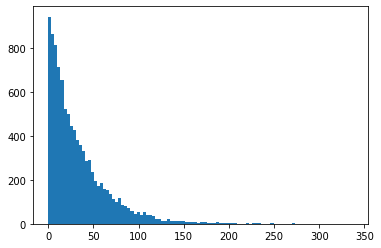

In [17]:
ex = stats.expon(scale=1/bd.t)
x = ex.rvs(10000)
plt.hist(x, bins=100);

binning an unbinned sample

In [18]:
n_histograms = 10000
n_events = 30000
xbin_edges = 9,12

between = lambda x, l1,l2: np.sum((x>=l1)&(x<=l2))
x1 = np.r_[[between(ex.rvs(n_events), *xbin_edges) for _ in range(n_histograms)]]

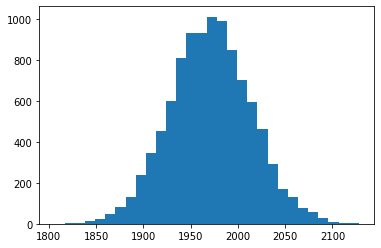

In [19]:
plt.hist(x1, bins=30);

In [20]:
Eni = (ex.cdf(xbin_edges[1])-ex.cdf(xbin_edges[0]))*n_events
print ("analytic expected value for the bin", Eni)

analytic expected value for the bin 1971.0950479746627


In [21]:
np.mean(x1), np.std(x1)

(1971.0843, 42.794441151976734)

sampling from the corresponding Poisson

- **observe the stds are different if the bin size if > 3 or 4**


In [22]:
pois = stats.poisson(mu=Eni)
h1 = pois.rvs(n_histograms)
np.mean(h1), np.std(h1)

(1971.243, 44.51188999582022)

in  https://www.physi.uni-heidelberg.de/~menzemer/Stat10/statistik_15.06.10.pdf slide 15, mentions that "Uncertainties are slightly larger than in unbinned fit", this might be what we are observing here

In [23]:
Eni, np.sqrt(Eni)

(1971.0950479746627, 44.39701620576165)

## MLE through optimization

In [24]:
optimized_params, optimized_bh = bd.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s", "t"], 
                                        observed_data=x_samples, verbose=True)

NameError: name 'x_samples' is not defined

In [25]:
optimized_params, optimized_bh = bd.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s"], 
                                        observed_data=x, verbose=True)

fixed params     {'stot': 100, 'btot': 1000, 'mu_s': 60.0, 'sigma_s': 6.0}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 5000], 'stot': [0, 5000], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'t': 8.825483860285688, 'mu': 8.458889081183166}
optimized params {'t': 13.398513532878567, 'mu': 0.00994898662730764}
expected params  {'t': 0.03, 'mu': 3.0}

 final_simplex: (array([[1.33985135e+01, 9.94898663e-03],
       [1.33985135e+01, 9.94898663e-03],
       [1.33985135e+01, 9.94898663e-03]]), array([45136.48998125, 45136.48998125, 45136.48998125]))
           fun: 45136.48998124992
       message: 'Optimization terminated successfully.'
          nfev: 288
           nit: 102
        status: 0
       success: True
             x: array([1.33985135e+01, 9.94898663e-03])
